# WEATHER PREDICTION USING LINEAR REGRESSION

_**Predicting apparent temperature using Linear Regression.**_

In [1]:
# Imports required packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

## Data Collection

In [2]:
# Loads dataset from csv file
weather = pd.read_csv("weather.csv")

# Displays few of the instances from the dataset
display(weather.head())

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## Exploratory Data Analysis (EDA)

In [3]:
# Checks for basic information about the dataset

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


**Observations from the basic dataset information are as follows.**

- Column "Precip Type" has missing values
- Out of 12 columns 4 columns are of non-numeric

In [4]:
# Checks for the descriptive statistics of the dataset

weather.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


Observations from the basic descriptive statistics are as follows.

- Column "Loud Cover" is single-valued
- Columns have different scales

**Finds values associated with non-numerical/categorical columns.**

In [5]:
# Finds values associated with "Summary"

print(weather.Summary.value_counts())

print("\nTotal unique value", weather.Summary.nunique())

Summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Hu

In [6]:
# Finds values associated with "Precip Type"

print(weather["Precip Type"].value_counts())

print("\nTotal unique value", weather["Precip Type"].nunique())

Precip Type
rain    85224
snow    10712
Name: count, dtype: int64

Total unique value 2


In [7]:
# Finds values associated with "Daily Summary"

print(weather["Daily Summary"].value_counts())

print("\nTotal unique value", weather["Daily Summary"].nunique())

Daily Summary
Mostly cloudy throughout the day.                                                                       20085
Partly cloudy throughout the day.                                                                        9981
Partly cloudy until night.                                                                               6169
Partly cloudy starting in the morning.                                                                   5184
Foggy in the morning.                                                                                    4201
                                                                                                        ...  
Breezy starting overnight continuing until morning and foggy overnight.                                    24
Mostly cloudy throughout the day and breezy starting overnight continuing until afternoon.                 24
Partly cloudy starting in the morning and breezy starting in the afternoon continuing until evening.      

In [8]:
# Check for missing values against each categorical column

weather[["Summary", "Precip Type", "Daily Summary"]].isnull().sum()

Summary            0
Precip Type      517
Daily Summary      0
dtype: int64

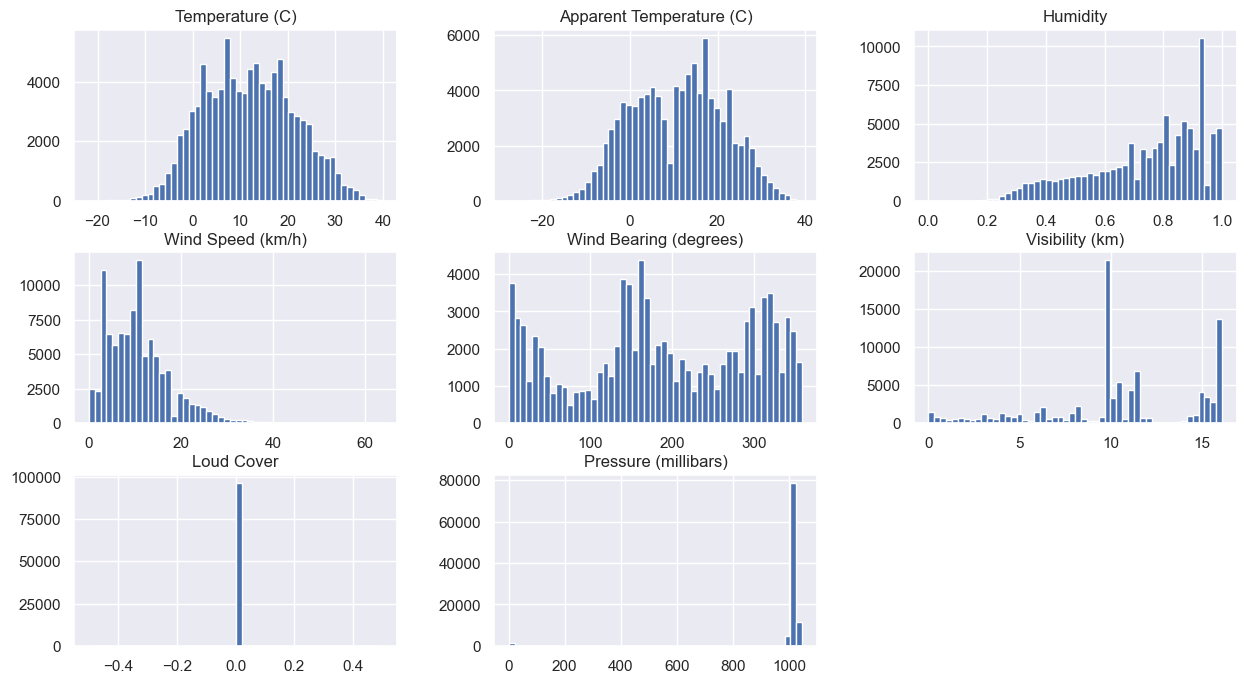

In [9]:
# Initializes default Seaborn theme
sns.set_theme()

# Plot histogram of each numeric feature analyze distribution of data
weather.hist(bins=50, figsize=(15,8))
plt.show()

From the above distribution, feature "Humidity", "Wind Speed (km/h)" and "Pressure (millibars)" could have outliers.
A boxplot of each of these features are plotted below for further analysis.

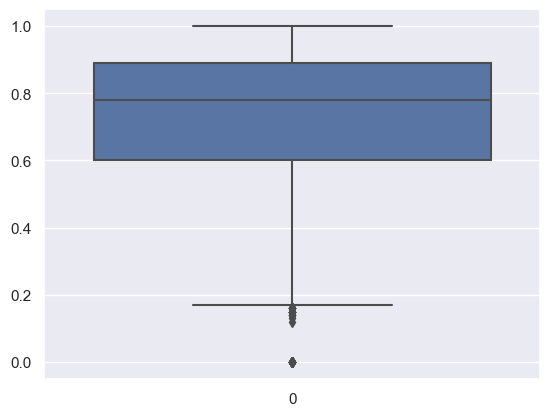

In [10]:
sns.boxplot(weather.Humidity)
plt.show()

Only therRows with above-zero humidity are to be considered.

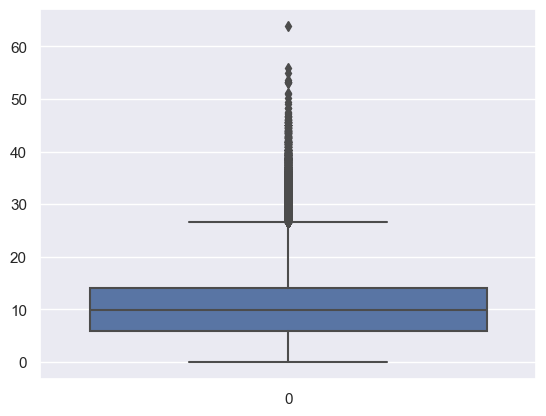

In [11]:
sns.boxplot(weather["Wind Speed (km/h)"])
plt.show()

Only the rows with less than 60 km/h wind speed are to be considered.

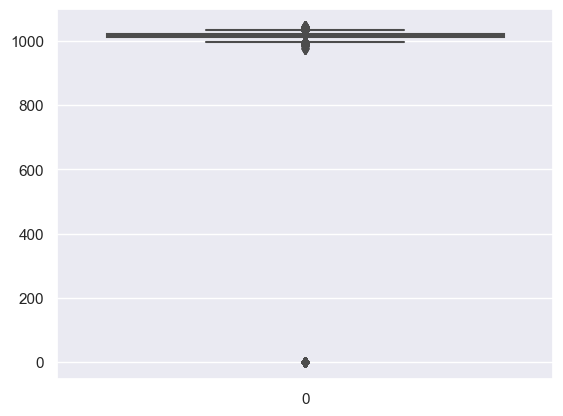

In [12]:
sns.boxplot(weather["Pressure (millibars)"])
plt.show()

Only the rows with above-zero pressure (millibars) are to be considered.

All the outliers identified above will be dropped in the following section.

## Preparing Data

### Checking for Duplicates and Single-valued Columns

**Removes duplicate observations, if any**

In [14]:
# Drops duplicate instances, if any
weather.drop_duplicates(keep='first', inplace=True)

**Removes single-valued columns**

In [15]:
weather.drop(columns=["Loud Cover"], axis=1, inplace=True)
print("\nData shape after single-value column removal:", weather.shape)


Data shape after single-value column removal: (96429, 11)


### Removing Outliers

In [16]:
# Removes the outliers as found from the ealier analysis

weather = weather[weather['Humidity'] != 0.0]
weather = weather[weather['Wind Speed (km/h)'] <= 60]
weather = weather[weather['Pressure (millibars)'] > 0]
weather.shape

(95118, 11)

### Removes Other Columns and Rows

In [17]:
# Removes column "Formatted Date" as no time-series analysis is being performed.

weather.drop(columns=["Formatted Date"], axis=1, inplace=True)
weather.shape

(95118, 10)

In [18]:
# As number of rows with missing "Precip Type" is just a tiny portion of 
# total number of rows, those rows are gets removed

weather.dropna(subset=["Precip Type"], axis=0, inplace=True)

In [19]:
# Resets index of the DataFrame to have continguous index numbers before further processing
weather.reset_index(inplace=True, drop=True)

In [20]:
#Shows the post-preprocessing shape of the data
print(weather.shape)

(94601, 10)


### Seperating Test Set

**To ensure same distribution both in training and test dataset and to make test dataset representative of the population, stratified sampling over column "Temperature (C)" was consisdered.**

In [21]:
# Creates a column on which stratification will be based on. Essentially, it is a column
# having values each would be a temperature bin that an instance will be associated to.

weather["Temperature_bin"] = pd.cut(
    weather["Temperature (C)"],                       # Values to be binned
    bins=[-30., -10., 0.0, 10., 20., 30., np.inf],    # Creates six bins
    labels=[1, 2, 3, 4, 5, 6])                        # Associates labels to each bin

In [22]:
# Splits data into train and test dataset applying stratification

train_set, test_set = train_test_split(
    weather, test_size = 0.2, stratify = weather["Temperature_bin"], random_state=42)

In [23]:
# Removes intermediate attribute 'Temperature_bin' after stratification
# as this would no more be required

train_set.drop("Temperature_bin", axis=1, inplace=True)
test_set.drop("Temperature_bin", axis=1, inplace=True)

### Seperating Target Column

In [24]:
# Seperates target from features for both training and test set

X_train = train_set.drop("Apparent Temperature (C)", axis = 1)
target_train = train_set["Apparent Temperature (C)"].copy()

X_test = test_set.drop("Apparent Temperature (C)", axis = 1)
target_test = test_set["Apparent Temperature (C)"].copy()

### Transforming Data

#### Transforming Training Data

**Creating transformation pipeline to impute missing and scale numeric data in training dataset**

In [25]:
# Sets list of numerical and categorical attributes

cat_attribs = ["Summary", "Precip Type", "Daily Summary"]
num_attribs = list(X_train.columns)
num_attribs.remove(cat_attribs[0])
num_attribs.remove(cat_attribs[1])
num_attribs.remove(cat_attribs[2])

In [26]:
# Setting data transformation pipeline for numerical attributes
# Note that featue scaling is NOT required for algorithms to be used here

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    #("std_scaler", StandardScaler())    # Not required
])

In [27]:
# Transforms both numerical and categorical attritues by using ColumnTransformer. 

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),      # Uses sub-pipeline already defined above
    ("cat", OneHotEncoder(), cat_attribs)])  # Considering OneHot encoding will just be fine for handful values

X_train_transformed = full_pipeline.fit_transform(X_train)

In [28]:
# Checks for the shape of the transformed training dataset

X_train_transformed.shape

(75680, 248)

#### Transforming Testing Data

In [29]:
X_test_transformed = full_pipeline.transform(X_test)

In [30]:
# Checks for the shape of the transformed testing dataset

X_test_transformed.shape

(18921, 248)

## Modeling

### Modeling Using Closed Form Approach

**Using Singular Value Decomposition (SVD) Approach over LinearRegression (LR) Algorithm**

In [ ]:
# Fits a LinearRegression model

lr_model = LinearRegression()
lr_model.fit(X_train_transformed, target_train)

In [ ]:
# Performs predictions on both training and testing dataset

predictions_train_lr = lr_model.predict(X_train_transformed)
predictions_test_lr = lr_model.predict(X_test_transformed)

In [ ]:
rmse_train_lr = np.sqrt(mean_squared_error(target_train, predictions_train_lr))
rmse_test_lr = np.sqrt(mean_squared_error(target_test, predictions_test_lr))

### Analyzing Model Performance
_Note that cross validation was not used for not being useful for closed form modeling approaches._

In [ ]:
# Shows Linear Regression model performance on both datasets

print("Linear Regression Model Peroformance (in RMSE):\n")
print("Train Error:", rmse_train_lr)
print("Test Error:", rmse_test_lr)

In [ ]:
# Shows models' prediction and prediction error side-by-side 
# on few of the instances from the test dataset

pd.DataFrame({
    "Actual Target": target_test, 
    "LR Prediction": predictions_test_lr, 
    "LR Prediction Error:": np.abs(target_test - predictions_test_lr)
}).head(10)